In [1]:
%load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib,imblearn

Using TensorFlow backend.


Chan 2019-08-21 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
konlpy 0.5.1
tensorflow 1.14.0
matplotlib 3.1.0
imblearn 0.5.0


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
import pickle

# Load datasets

In [3]:
datasets = pd.read_csv('../../data/train.csv', engine='python', encoding='utf-16')
datasets.head()

,Unnamed: 0,comment,url_id,label
0,0,ㅜㅜ,77,0
1,1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,17,0
2,2,헐,52,0
3,3,제시,75,0
4,4,이거인 듯,18,0


In [4]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 4 columns):
Unnamed: 0    42000 non-null int64
comment       42000 non-null object
url_id        42000 non-null int64
label         42000 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


In [5]:
morped =[_.encode('utf-8') for _ in tqdm(datasets.comment)]
morped[:5]

100%|████████████████████████████████████████████████████████████████████████| 42000/42000 [00:00<00:00, 382044.61it/s]


[b'\xe3\x85\x9c\xe3\x85\x9c',
 b'\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b',
 b'\xed\x97\x90',
 b'\xec\xa0\x9c\xec\x8b\x9c',
 b'\xec\x9d\xb4\xea\xb1\xb0\xec\x9d\xb8 \xeb\x93\xaf']

In [6]:
bytarr = []
[bytarr.append([str(_) for _ in morped[i]]) for i in range(len(morped))]
bytarr[:5]

[['227', '133', '156', '227', '133', '156'],
 ['227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139'],
 ['237', '151', '144'],
 ['236', '160', '156', '236', '139', '156'],
 ['236',
  '157',
  '180',
  '234',
  '177',
  '176',
  '236',
  '157',
  '184',
  '32',
  '235',
  '147',
  '175']]

# 형태소분석

In [23]:
vocab_size = 175

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

    vocab = {
    '<PAD>': pad_id,
    '<OOV>': oov_id
    }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[str(word)] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(bytarr)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

# # vocab save
# with open('./vocab/vocab_index.pickle', 'wb') as f:
#     pickle.dump(word_index, f, pickle.HIGHEST_PROTOCOL)
# with open('./vocab/vocab_inverted_index.pickle', 'wb') as f:
#     pickle.dump(word_inverted_index, f, pickle.HIGHEST_PROTOCOL)

고빈도 단어:
133 :  94992
227 :  94926
139 :  94675
236 :  85378
235 :  70509
32 :  42738
132 :  25626
234 :  24976
180 :  21650
176 :  21395

단어 사전:
0 <PAD>
1 <OOV>
2 133
3 227
4 139
5 236
6 235
7 32
8 132
9 234

단어 사전 크기:  175


In [24]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", bytarr[0])
ids = text_to_index(bytarr[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['227', '133', '156', '227', '133', '156']
문자 -> 숫자:  [3, 2, 19, 3, 2, 19]
숫자 -> 문자:  227 133 156 227 133 156


In [25]:
x_variable = [text_to_index(_) for _ in bytarr]

sentence_size = 50
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

In [26]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

In [27]:
import warnings
warnings.filterwarnings(action='once')


# 데이터 클래스 불균형 문제 해결하자

In [28]:
from imblearn.under_sampling import RandomUnderSampler

In [29]:
down_X, down_y = RandomUnderSampler().fit_resample(x_padded, datasets.label)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(down_X, down_y)

In [31]:
# 총 데이터 수 , 1 레이블 데이터 수
len(down_y), down_y.sum()

(4192, 2096)

In [87]:
model = keras.Sequential([
    keras.layers.Embedding(175, 32),
    keras.layers.Conv1D(128, 16, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(128, 8, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(64, 8, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(64, 4, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 4, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

Train on 3144 samples, validate on 1048 samples
Epoch 1/40
3144/3144 [==============================] - ETA: 3:49 - loss: 0.6885 - recall_11: 0.156 - ETA: 2:00 - loss: 0.6917 - recall_11: 0.140 - ETA: 1:25 - loss: 0.6932 - recall_11: 0.187 - ETA: 1:07 - loss: 0.6962 - recall_11: 0.203 - ETA: 57s - loss: 0.6958 - recall_11: 0.193 - ETA: 50s - loss: 0.6973 - recall_11: 0.18 - ETA: 45s - loss: 0.6958 - recall_11: 0.20 - ETA: 41s - loss: 0.6960 - recall_11: 0.19 - ETA: 41s - loss: 0.6958 - recall_11: 0.20 - ETA: 40s - loss: 0.6959 - recall_11: 0.20 - ETA: 37s - loss: 0.6958 - recall_11: 0.21 - ETA: 35s - loss: 0.6959 - recall_11: 0.21 - ETA: 36s - loss: 0.6962 - recall_11: 0.21 - ETA: 37s - loss: 0.6966 - recall_11: 0.22 - ETA: 36s - loss: 0.6968 - recall_11: 0.23 - ETA: 35s - loss: 0.6967 - recall_11: 0.24 - ETA: 33s - loss: 0.6964 - recall_11: 0.25 - ETA: 32s - loss: 0.6959 - recall_11: 0.26 - ETA: 31s - loss: 0.6958 - recall_11: 0.27 - ETA: 30s - loss: 0.6957 - recall_11: 0.29 - ETA: 28

3144/3144 [==============================] - ETA: 16s - loss: 0.6972 - recall_11: 0.53 - ETA: 15s - loss: 0.6867 - recall_11: 0.64 - ETA: 14s - loss: 0.6892 - recall_11: 0.62 - ETA: 15s - loss: 0.6925 - recall_11: 0.58 - ETA: 15s - loss: 0.6911 - recall_11: 0.63 - ETA: 16s - loss: 0.6910 - recall_11: 0.62 - ETA: 16s - loss: 0.6922 - recall_11: 0.62 - ETA: 15s - loss: 0.6947 - recall_11: 0.62 - ETA: 15s - loss: 0.6933 - recall_11: 0.64 - ETA: 14s - loss: 0.6927 - recall_11: 0.65 - ETA: 14s - loss: 0.6925 - recall_11: 0.65 - ETA: 13s - loss: 0.6925 - recall_11: 0.66 - ETA: 13s - loss: 0.6924 - recall_11: 0.66 - ETA: 13s - loss: 0.6928 - recall_11: 0.65 - ETA: 13s - loss: 0.6920 - recall_11: 0.65 - ETA: 13s - loss: 0.6912 - recall_11: 0.66 - ETA: 12s - loss: 0.6910 - recall_11: 0.66 - ETA: 12s - loss: 0.6913 - recall_11: 0.66 - ETA: 12s - loss: 0.6913 - recall_11: 0.65 - ETA: 13s - loss: 0.6919 - recall_11: 0.65 - ETA: 13s - loss: 0.6917 - recall_11: 0.65 - ETA: 13s - loss: 0.6913 - recal

3144/3144 [==============================] - ETA: 1:18 - loss: 0.7332 - recall_11: 0.593 - ETA: 1:27 - loss: 0.6974 - recall_11: 0.671 - ETA: 1:35 - loss: 0.6903 - recall_11: 0.708 - ETA: 1:20 - loss: 0.6920 - recall_11: 0.679 - ETA: 1:07 - loss: 0.6885 - recall_11: 0.681 - ETA: 57s - loss: 0.6898 - recall_11: 0.682 - ETA: 51s - loss: 0.6888 - recall_11: 0.66 - ETA: 46s - loss: 0.6853 - recall_11: 0.68 - ETA: 42s - loss: 0.6840 - recall_11: 0.69 - ETA: 39s - loss: 0.6840 - recall_11: 0.69 - ETA: 36s - loss: 0.6827 - recall_11: 0.70 - ETA: 34s - loss: 0.6819 - recall_11: 0.70 - ETA: 32s - loss: 0.6828 - recall_11: 0.70 - ETA: 30s - loss: 0.6836 - recall_11: 0.70 - ETA: 28s - loss: 0.6816 - recall_11: 0.70 - ETA: 27s - loss: 0.6788 - recall_11: 0.71 - ETA: 26s - loss: 0.6777 - recall_11: 0.71 - ETA: 25s - loss: 0.6784 - recall_11: 0.70 - ETA: 24s - loss: 0.6757 - recall_11: 0.71 - ETA: 23s - loss: 0.6789 - recall_11: 0.70 - ETA: 22s - loss: 0.6803 - recall_11: 0.70 - ETA: 21s - loss: 0.6

3144/3144 [==============================] - ETA: 14s - loss: 0.5940 - recall_11: 0.75 - ETA: 13s - loss: 0.6225 - recall_11: 0.73 - ETA: 13s - loss: 0.6392 - recall_11: 0.68 - ETA: 13s - loss: 0.6048 - recall_11: 0.72 - ETA: 12s - loss: 0.6202 - recall_11: 0.68 - ETA: 12s - loss: 0.6197 - recall_11: 0.68 - ETA: 12s - loss: 0.6137 - recall_11: 0.69 - ETA: 14s - loss: 0.6175 - recall_11: 0.67 - ETA: 14s - loss: 0.6179 - recall_11: 0.67 - ETA: 15s - loss: 0.6182 - recall_11: 0.67 - ETA: 14s - loss: 0.6145 - recall_11: 0.67 - ETA: 14s - loss: 0.6094 - recall_11: 0.68 - ETA: 14s - loss: 0.6069 - recall_11: 0.69 - ETA: 13s - loss: 0.6021 - recall_11: 0.69 - ETA: 13s - loss: 0.6022 - recall_11: 0.68 - ETA: 13s - loss: 0.5986 - recall_11: 0.68 - ETA: 12s - loss: 0.6089 - recall_11: 0.66 - ETA: 12s - loss: 0.6080 - recall_11: 0.67 - ETA: 12s - loss: 0.6030 - recall_11: 0.67 - ETA: 11s - loss: 0.6035 - recall_11: 0.67 - ETA: 11s - loss: 0.6053 - recall_11: 0.67 - ETA: 11s - loss: 0.6060 - recal

3144/3144 [==============================] - ETA: 14s - loss: 0.6891 - recall_11: 0.59 - ETA: 15s - loss: 0.6436 - recall_11: 0.65 - ETA: 16s - loss: 0.6615 - recall_11: 0.65 - ETA: 16s - loss: 0.6558 - recall_11: 0.67 - ETA: 15s - loss: 0.6452 - recall_11: 0.66 - ETA: 15s - loss: 0.6323 - recall_11: 0.67 - ETA: 15s - loss: 0.6122 - recall_11: 0.70 - ETA: 15s - loss: 0.6175 - recall_11: 0.68 - ETA: 14s - loss: 0.6094 - recall_11: 0.69 - ETA: 14s - loss: 0.6092 - recall_11: 0.70 - ETA: 13s - loss: 0.6041 - recall_11: 0.71 - ETA: 13s - loss: 0.6017 - recall_11: 0.70 - ETA: 13s - loss: 0.5981 - recall_11: 0.70 - ETA: 13s - loss: 0.5995 - recall_11: 0.69 - ETA: 13s - loss: 0.5975 - recall_11: 0.69 - ETA: 13s - loss: 0.5954 - recall_11: 0.69 - ETA: 12s - loss: 0.5892 - recall_11: 0.70 - ETA: 12s - loss: 0.5930 - recall_11: 0.69 - ETA: 12s - loss: 0.5930 - recall_11: 0.69 - ETA: 12s - loss: 0.5913 - recall_11: 0.69 - ETA: 11s - loss: 0.5943 - recall_11: 0.69 - ETA: 11s - loss: 0.5908 - recal

3144/3144 [==============================] - ETA: 25s - loss: 0.5559 - recall_11: 0.65 - ETA: 29s - loss: 0.6269 - recall_11: 0.65 - ETA: 26s - loss: 0.5974 - recall_11: 0.69 - ETA: 24s - loss: 0.5618 - recall_11: 0.72 - ETA: 22s - loss: 0.5409 - recall_11: 0.74 - ETA: 20s - loss: 0.5529 - recall_11: 0.73 - ETA: 22s - loss: 0.5500 - recall_11: 0.74 - ETA: 21s - loss: 0.5364 - recall_11: 0.75 - ETA: 21s - loss: 0.5388 - recall_11: 0.74 - ETA: 22s - loss: 0.5223 - recall_11: 0.75 - ETA: 22s - loss: 0.5175 - recall_11: 0.75 - ETA: 21s - loss: 0.5103 - recall_11: 0.76 - ETA: 25s - loss: 0.5149 - recall_11: 0.76 - ETA: 24s - loss: 0.5129 - recall_11: 0.75 - ETA: 24s - loss: 0.5105 - recall_11: 0.75 - ETA: 24s - loss: 0.5067 - recall_11: 0.75 - ETA: 24s - loss: 0.4979 - recall_11: 0.76 - ETA: 24s - loss: 0.4924 - recall_11: 0.76 - ETA: 25s - loss: 0.4982 - recall_11: 0.76 - ETA: 24s - loss: 0.5004 - recall_11: 0.75 - ETA: 24s - loss: 0.4972 - recall_11: 0.76 - ETA: 24s - loss: 0.5035 - recal

3144/3144 [==============================] - ETA: 19s - loss: 0.4975 - recall_11: 0.78 - ETA: 20s - loss: 0.4834 - recall_11: 0.76 - ETA: 22s - loss: 0.4524 - recall_11: 0.76 - ETA: 21s - loss: 0.5197 - recall_11: 0.75 - ETA: 20s - loss: 0.4852 - recall_11: 0.77 - ETA: 19s - loss: 0.4773 - recall_11: 0.77 - ETA: 18s - loss: 0.4952 - recall_11: 0.77 - ETA: 17s - loss: 0.4908 - recall_11: 0.77 - ETA: 16s - loss: 0.4916 - recall_11: 0.77 - ETA: 16s - loss: 0.4776 - recall_11: 0.79 - ETA: 16s - loss: 0.4788 - recall_11: 0.79 - ETA: 15s - loss: 0.4806 - recall_11: 0.79 - ETA: 15s - loss: 0.4884 - recall_11: 0.79 - ETA: 14s - loss: 0.4967 - recall_11: 0.78 - ETA: 14s - loss: 0.4958 - recall_11: 0.77 - ETA: 14s - loss: 0.4928 - recall_11: 0.77 - ETA: 14s - loss: 0.4985 - recall_11: 0.76 - ETA: 15s - loss: 0.4925 - recall_11: 0.77 - ETA: 15s - loss: 0.4945 - recall_11: 0.76 - ETA: 15s - loss: 0.4971 - recall_11: 0.76 - ETA: 15s - loss: 0.4980 - recall_11: 0.76 - ETA: 14s - loss: 0.4965 - recal

3144/3144 [==============================] - ETA: 14s - loss: 0.4091 - recall_11: 0.87 - ETA: 14s - loss: 0.5907 - recall_11: 0.81 - ETA: 13s - loss: 0.5468 - recall_11: 0.78 - ETA: 14s - loss: 0.5390 - recall_11: 0.77 - ETA: 14s - loss: 0.5101 - recall_11: 0.78 - ETA: 14s - loss: 0.5149 - recall_11: 0.77 - ETA: 14s - loss: 0.5078 - recall_11: 0.77 - ETA: 14s - loss: 0.5007 - recall_11: 0.77 - ETA: 14s - loss: 0.4886 - recall_11: 0.78 - ETA: 13s - loss: 0.5100 - recall_11: 0.76 - ETA: 13s - loss: 0.4946 - recall_11: 0.77 - ETA: 13s - loss: 0.4844 - recall_11: 0.78 - ETA: 14s - loss: 0.4776 - recall_11: 0.79 - ETA: 15s - loss: 0.4841 - recall_11: 0.79 - ETA: 16s - loss: 0.4881 - recall_11: 0.78 - ETA: 16s - loss: 0.4812 - recall_11: 0.78 - ETA: 16s - loss: 0.4792 - recall_11: 0.78 - ETA: 15s - loss: 0.4779 - recall_11: 0.78 - ETA: 15s - loss: 0.4719 - recall_11: 0.78 - ETA: 15s - loss: 0.4740 - recall_11: 0.78 - ETA: 15s - loss: 0.4821 - recall_11: 0.78 - ETA: 14s - loss: 0.4826 - recal

3144/3144 [==============================] - ETA: 13s - loss: 0.5597 - recall_11: 0.71 - ETA: 14s - loss: 0.4875 - recall_11: 0.79 - ETA: 15s - loss: 0.4913 - recall_11: 0.77 - ETA: 20s - loss: 0.5193 - recall_11: 0.73 - ETA: 27s - loss: 0.5163 - recall_11: 0.73 - ETA: 32s - loss: 0.5065 - recall_11: 0.75 - ETA: 29s - loss: 0.5005 - recall_11: 0.75 - ETA: 27s - loss: 0.4948 - recall_11: 0.76 - ETA: 25s - loss: 0.5007 - recall_11: 0.76 - ETA: 24s - loss: 0.4982 - recall_11: 0.76 - ETA: 23s - loss: 0.4998 - recall_11: 0.76 - ETA: 23s - loss: 0.5017 - recall_11: 0.76 - ETA: 22s - loss: 0.5000 - recall_11: 0.76 - ETA: 21s - loss: 0.5180 - recall_11: 0.76 - ETA: 21s - loss: 0.5105 - recall_11: 0.76 - ETA: 20s - loss: 0.5110 - recall_11: 0.76 - ETA: 20s - loss: 0.5025 - recall_11: 0.77 - ETA: 20s - loss: 0.4972 - recall_11: 0.77 - ETA: 21s - loss: 0.4926 - recall_11: 0.77 - ETA: 20s - loss: 0.4912 - recall_11: 0.78 - ETA: 19s - loss: 0.4896 - recall_11: 0.78 - ETA: 19s - loss: 0.4871 - recal

3144/3144 [==============================] - ETA: 19s - loss: 0.4247 - recall_11: 0.81 - ETA: 17s - loss: 0.3580 - recall_11: 0.84 - ETA: 16s - loss: 0.3496 - recall_11: 0.86 - ETA: 16s - loss: 0.3560 - recall_11: 0.85 - ETA: 15s - loss: 0.3866 - recall_11: 0.83 - ETA: 14s - loss: 0.3788 - recall_11: 0.83 - ETA: 14s - loss: 0.3855 - recall_11: 0.83 - ETA: 13s - loss: 0.3827 - recall_11: 0.83 - ETA: 13s - loss: 0.3768 - recall_11: 0.84 - ETA: 13s - loss: 0.3788 - recall_11: 0.83 - ETA: 12s - loss: 0.3663 - recall_11: 0.84 - ETA: 12s - loss: 0.3680 - recall_11: 0.85 - ETA: 13s - loss: 0.3623 - recall_11: 0.85 - ETA: 12s - loss: 0.3644 - recall_11: 0.85 - ETA: 12s - loss: 0.3699 - recall_11: 0.84 - ETA: 12s - loss: 0.3653 - recall_11: 0.85 - ETA: 12s - loss: 0.3888 - recall_11: 0.84 - ETA: 12s - loss: 0.4129 - recall_11: 0.84 - ETA: 12s - loss: 0.4041 - recall_11: 0.85 - ETA: 12s - loss: 0.3952 - recall_11: 0.85 - ETA: 11s - loss: 0.3934 - recall_11: 0.85 - ETA: 12s - loss: 0.4009 - recal

3144/3144 [==============================] - ETA: 13s - loss: 0.2890 - recall_11: 0.96 - ETA: 20s - loss: 0.3086 - recall_11: 0.93 - ETA: 19s - loss: 0.3598 - recall_11: 0.88 - ETA: 20s - loss: 0.3541 - recall_11: 0.88 - ETA: 21s - loss: 0.3725 - recall_11: 0.85 - ETA: 24s - loss: 0.3573 - recall_11: 0.86 - ETA: 24s - loss: 0.3744 - recall_11: 0.86 - ETA: 24s - loss: 0.3911 - recall_11: 0.85 - ETA: 23s - loss: 0.3848 - recall_11: 0.85 - ETA: 22s - loss: 0.3978 - recall_11: 0.84 - ETA: 21s - loss: 0.3920 - recall_11: 0.84 - ETA: 21s - loss: 0.3769 - recall_11: 0.85 - ETA: 20s - loss: 0.3683 - recall_11: 0.85 - ETA: 20s - loss: 0.3604 - recall_11: 0.86 - ETA: 20s - loss: 0.3742 - recall_11: 0.85 - ETA: 19s - loss: 0.3754 - recall_11: 0.85 - ETA: 19s - loss: 0.3788 - recall_11: 0.85 - ETA: 19s - loss: 0.3765 - recall_11: 0.85 - ETA: 18s - loss: 0.3768 - recall_11: 0.85 - ETA: 18s - loss: 0.3696 - recall_11: 0.85 - ETA: 17s - loss: 0.3697 - recall_11: 0.85 - ETA: 17s - loss: 0.3742 - recal

3144/3144 [==============================] - ETA: 16s - loss: 0.2095 - recall_11: 0.93 - ETA: 16s - loss: 0.2098 - recall_11: 0.93 - ETA: 16s - loss: 0.2570 - recall_11: 0.90 - ETA: 16s - loss: 0.2950 - recall_11: 0.89 - ETA: 16s - loss: 0.3018 - recall_11: 0.88 - ETA: 15s - loss: 0.2938 - recall_11: 0.89 - ETA: 15s - loss: 0.3265 - recall_11: 0.87 - ETA: 15s - loss: 0.3094 - recall_11: 0.87 - ETA: 14s - loss: 0.3020 - recall_11: 0.87 - ETA: 14s - loss: 0.3038 - recall_11: 0.87 - ETA: 14s - loss: 0.3081 - recall_11: 0.87 - ETA: 14s - loss: 0.3129 - recall_11: 0.87 - ETA: 16s - loss: 0.3059 - recall_11: 0.87 - ETA: 17s - loss: 0.3038 - recall_11: 0.88 - ETA: 16s - loss: 0.3013 - recall_11: 0.88 - ETA: 16s - loss: 0.3027 - recall_11: 0.87 - ETA: 16s - loss: 0.3023 - recall_11: 0.88 - ETA: 15s - loss: 0.3073 - recall_11: 0.88 - ETA: 15s - loss: 0.3050 - recall_11: 0.88 - ETA: 14s - loss: 0.3110 - recall_11: 0.87 - ETA: 14s - loss: 0.3120 - recall_11: 0.87 - ETA: 14s - loss: 0.3149 - recal

3144/3144 [==============================] - ETA: 3:30 - loss: 0.3254 - recall_11: 0.906 - ETA: 3:01 - loss: 0.3524 - recall_11: 0.890 - ETA: 3:29 - loss: 0.3330 - recall_11: 0.875 - ETA: 3:17 - loss: 0.3124 - recall_11: 0.882 - ETA: 2:59 - loss: 0.2895 - recall_11: 0.893 - ETA: 2:55 - loss: 0.3011 - recall_11: 0.885 - ETA: 2:48 - loss: 0.2901 - recall_11: 0.892 - ETA: 2:40 - loss: 0.3252 - recall_11: 0.871 - ETA: 2:33 - loss: 0.3196 - recall_11: 0.878 - ETA: 2:36 - loss: 0.3126 - recall_11: 0.881 - ETA: 2:37 - loss: 0.3013 - recall_11: 0.889 - ETA: 2:38 - loss: 0.2992 - recall_11: 0.888 - ETA: 2:37 - loss: 0.2970 - recall_11: 0.887 - ETA: 2:36 - loss: 0.2932 - recall_11: 0.886 - ETA: 2:34 - loss: 0.2966 - recall_11: 0.883 - ETA: 2:35 - loss: 0.3154 - recall_11: 0.871 - ETA: 2:34 - loss: 0.3112 - recall_11: 0.875 - ETA: 2:32 - loss: 0.3199 - recall_11: 0.871 - ETA: 2:28 - loss: 0.3200 - recall_11: 0.873 - ETA: 2:26 - loss: 0.3134 - recall_11: 0.876 - ETA: 2:23 - loss: 0.3170 - recall_1

3144/3144 [==============================] - ETA: 2:44 - loss: 0.2063 - recall_11: 0.937 - ETA: 2:37 - loss: 0.2242 - recall_11: 0.953 - ETA: 2:20 - loss: 0.2948 - recall_11: 0.895 - ETA: 2:17 - loss: 0.2564 - recall_11: 0.921 - ETA: 2:04 - loss: 0.2552 - recall_11: 0.918 - ETA: 1:50 - loss: 0.2553 - recall_11: 0.906 - ETA: 1:44 - loss: 0.2671 - recall_11: 0.892 - ETA: 1:46 - loss: 0.2629 - recall_11: 0.902 - ETA: 1:44 - loss: 0.2639 - recall_11: 0.906 - ETA: 1:48 - loss: 0.2758 - recall_11: 0.896 - ETA: 1:49 - loss: 0.2893 - recall_11: 0.900 - ETA: 1:46 - loss: 0.2880 - recall_11: 0.901 - ETA: 1:45 - loss: 0.2933 - recall_11: 0.896 - ETA: 1:38 - loss: 0.2905 - recall_11: 0.897 - ETA: 1:33 - loss: 0.2922 - recall_11: 0.893 - ETA: 1:28 - loss: 0.3012 - recall_11: 0.888 - ETA: 1:23 - loss: 0.2940 - recall_11: 0.893 - ETA: 1:19 - loss: 0.2974 - recall_11: 0.888 - ETA: 1:16 - loss: 0.2982 - recall_11: 0.886 - ETA: 1:14 - loss: 0.2995 - recall_11: 0.884 - ETA: 1:15 - loss: 0.2941 - recall_1

3144/3144 [==============================] - ETA: 33s - loss: 0.2866 - recall_11: 0.84 - ETA: 43s - loss: 0.3134 - recall_11: 0.87 - ETA: 52s - loss: 0.3443 - recall_11: 0.86 - ETA: 1:10 - loss: 0.3137 - recall_11: 0.875 - ETA: 1:02 - loss: 0.3410 - recall_11: 0.856 - ETA: 57s - loss: 0.3133 - recall_11: 0.875 - ETA: 56s - loss: 0.3092 - recall_11: 0.87 - ETA: 56s - loss: 0.2937 - recall_11: 0.88 - ETA: 1:02 - loss: 0.3114 - recall_11: 0.875 - ETA: 1:09 - loss: 0.3023 - recall_11: 0.878 - ETA: 1:15 - loss: 0.3051 - recall_11: 0.872 - ETA: 1:15 - loss: 0.2987 - recall_11: 0.877 - ETA: 1:23 - loss: 0.2917 - recall_11: 0.882 - ETA: 1:24 - loss: 0.2912 - recall_11: 0.877 - ETA: 1:22 - loss: 0.3026 - recall_11: 0.875 - ETA: 1:20 - loss: 0.3124 - recall_11: 0.875 - ETA: 1:26 - loss: 0.3080 - recall_11: 0.876 - ETA: 1:25 - loss: 0.3031 - recall_11: 0.878 - ETA: 1:25 - loss: 0.3015 - recall_11: 0.878 - ETA: 1:29 - loss: 0.2950 - recall_11: 0.882 - ETA: 1:33 - loss: 0.2865 - recall_11: 0.885 - 

3144/3144 [==============================] - ETA: 31s - loss: 0.0866 - recall_11: 1.00 - ETA: 28s - loss: 0.1291 - recall_11: 0.98 - ETA: 26s - loss: 0.1621 - recall_11: 0.95 - ETA: 26s - loss: 0.1621 - recall_11: 0.94 - ETA: 35s - loss: 0.1591 - recall_11: 0.93 - ETA: 51s - loss: 0.1816 - recall_11: 0.93 - ETA: 49s - loss: 0.1968 - recall_11: 0.91 - ETA: 48s - loss: 0.1983 - recall_11: 0.92 - ETA: 51s - loss: 0.2107 - recall_11: 0.92 - ETA: 55s - loss: 0.2101 - recall_11: 0.92 - ETA: 54s - loss: 0.2176 - recall_11: 0.92 - ETA: 57s - loss: 0.2184 - recall_11: 0.92 - ETA: 1:04 - loss: 0.2320 - recall_11: 0.920 - ETA: 1:01 - loss: 0.2224 - recall_11: 0.926 - ETA: 1:01 - loss: 0.2173 - recall_11: 0.927 - ETA: 1:00 - loss: 0.2195 - recall_11: 0.927 - ETA: 1:01 - loss: 0.2356 - recall_11: 0.921 - ETA: 1:01 - loss: 0.2346 - recall_11: 0.920 - ETA: 59s - loss: 0.2304 - recall_11: 0.921 - ETA: 56s - loss: 0.2287 - recall_11: 0.92 - ETA: 56s - loss: 0.2252 - recall_11: 0.91 - ETA: 53s - loss: 0

3144/3144 [==============================] - ETA: 13s - loss: 0.1758 - recall_11: 0.90 - ETA: 13s - loss: 0.2032 - recall_11: 0.90 - ETA: 13s - loss: 0.2071 - recall_11: 0.90 - ETA: 14s - loss: 0.2344 - recall_11: 0.89 - ETA: 14s - loss: 0.2740 - recall_11: 0.88 - ETA: 14s - loss: 0.2606 - recall_11: 0.88 - ETA: 13s - loss: 0.2538 - recall_11: 0.89 - ETA: 13s - loss: 0.2734 - recall_11: 0.88 - ETA: 13s - loss: 0.2544 - recall_11: 0.89 - ETA: 15s - loss: 0.2442 - recall_11: 0.90 - ETA: 18s - loss: 0.2326 - recall_11: 0.91 - ETA: 18s - loss: 0.2328 - recall_11: 0.91 - ETA: 18s - loss: 0.2294 - recall_11: 0.91 - ETA: 17s - loss: 0.2281 - recall_11: 0.91 - ETA: 16s - loss: 0.2255 - recall_11: 0.91 - ETA: 16s - loss: 0.2219 - recall_11: 0.91 - ETA: 16s - loss: 0.2229 - recall_11: 0.91 - ETA: 15s - loss: 0.2310 - recall_11: 0.91 - ETA: 15s - loss: 0.2379 - recall_11: 0.91 - ETA: 15s - loss: 0.2370 - recall_11: 0.91 - ETA: 14s - loss: 0.2298 - recall_11: 0.91 - ETA: 14s - loss: 0.2288 - recal

3144/3144 [==============================] - ETA: 19s - loss: 0.3338 - recall_11: 0.84 - ETA: 24s - loss: 0.3067 - recall_11: 0.87 - ETA: 28s - loss: 0.2414 - recall_11: 0.90 - ETA: 28s - loss: 0.2818 - recall_11: 0.91 - ETA: 31s - loss: 0.2637 - recall_11: 0.91 - ETA: 30s - loss: 0.2850 - recall_11: 0.91 - ETA: 28s - loss: 0.2804 - recall_11: 0.91 - ETA: 26s - loss: 0.2619 - recall_11: 0.91 - ETA: 25s - loss: 0.2772 - recall_11: 0.92 - ETA: 24s - loss: 0.2713 - recall_11: 0.91 - ETA: 24s - loss: 0.2528 - recall_11: 0.92 - ETA: 23s - loss: 0.2468 - recall_11: 0.92 - ETA: 24s - loss: 0.2562 - recall_11: 0.91 - ETA: 23s - loss: 0.2564 - recall_11: 0.91 - ETA: 22s - loss: 0.2464 - recall_11: 0.91 - ETA: 22s - loss: 0.2542 - recall_11: 0.91 - ETA: 21s - loss: 0.2554 - recall_11: 0.90 - ETA: 20s - loss: 0.2477 - recall_11: 0.91 - ETA: 19s - loss: 0.2540 - recall_11: 0.90 - ETA: 19s - loss: 0.2525 - recall_11: 0.90 - ETA: 18s - loss: 0.2473 - recall_11: 0.90 - ETA: 18s - loss: 0.2506 - recal

3144/3144 [==============================] - ETA: 13s - loss: 0.0709 - recall_11: 1.00 - ETA: 14s - loss: 0.1387 - recall_11: 0.95 - ETA: 18s - loss: 0.1157 - recall_11: 0.96 - ETA: 21s - loss: 0.1109 - recall_11: 0.97 - ETA: 20s - loss: 0.1385 - recall_11: 0.95 - ETA: 20s - loss: 0.1436 - recall_11: 0.95 - ETA: 19s - loss: 0.1478 - recall_11: 0.95 - ETA: 18s - loss: 0.1480 - recall_11: 0.94 - ETA: 17s - loss: 0.1697 - recall_11: 0.94 - ETA: 17s - loss: 0.1636 - recall_11: 0.94 - ETA: 17s - loss: 0.1527 - recall_11: 0.95 - ETA: 17s - loss: 0.1718 - recall_11: 0.94 - ETA: 16s - loss: 0.1639 - recall_11: 0.94 - ETA: 16s - loss: 0.1569 - recall_11: 0.95 - ETA: 16s - loss: 0.1555 - recall_11: 0.95 - ETA: 15s - loss: 0.1591 - recall_11: 0.94 - ETA: 15s - loss: 0.1545 - recall_11: 0.94 - ETA: 15s - loss: 0.1576 - recall_11: 0.94 - ETA: 14s - loss: 0.1717 - recall_11: 0.94 - ETA: 14s - loss: 0.1722 - recall_11: 0.94 - ETA: 14s - loss: 0.1718 - recall_11: 0.94 - ETA: 14s - loss: 0.1681 - recal

3144/3144 [==============================] - ETA: 17s - loss: 0.2297 - recall_11: 0.93 - ETA: 23s - loss: 0.1503 - recall_11: 0.96 - ETA: 29s - loss: 0.1352 - recall_11: 0.96 - ETA: 31s - loss: 0.1195 - recall_11: 0.96 - ETA: 31s - loss: 0.1225 - recall_11: 0.96 - ETA: 28s - loss: 0.1228 - recall_11: 0.95 - ETA: 26s - loss: 0.1466 - recall_11: 0.95 - ETA: 24s - loss: 0.1495 - recall_11: 0.94 - ETA: 23s - loss: 0.1478 - recall_11: 0.94 - ETA: 22s - loss: 0.1547 - recall_11: 0.94 - ETA: 21s - loss: 0.1514 - recall_11: 0.94 - ETA: 21s - loss: 0.1520 - recall_11: 0.94 - ETA: 21s - loss: 0.1487 - recall_11: 0.94 - ETA: 21s - loss: 0.1553 - recall_11: 0.94 - ETA: 20s - loss: 0.1487 - recall_11: 0.94 - ETA: 20s - loss: 0.1443 - recall_11: 0.94 - ETA: 19s - loss: 0.1482 - recall_11: 0.94 - ETA: 19s - loss: 0.1489 - recall_11: 0.94 - ETA: 19s - loss: 0.1527 - recall_11: 0.94 - ETA: 18s - loss: 0.1477 - recall_11: 0.94 - ETA: 17s - loss: 0.1434 - recall_11: 0.95 - ETA: 17s - loss: 0.1398 - recal

3144/3144 [==============================] - ETA: 13s - loss: 0.1068 - recall_11: 0.96 - ETA: 14s - loss: 0.1999 - recall_11: 0.92 - ETA: 14s - loss: 0.1592 - recall_11: 0.94 - ETA: 15s - loss: 0.1724 - recall_11: 0.92 - ETA: 23s - loss: 0.1799 - recall_11: 0.93 - ETA: 25s - loss: 0.1806 - recall_11: 0.92 - ETA: 23s - loss: 0.1817 - recall_11: 0.92 - ETA: 22s - loss: 0.1798 - recall_11: 0.92 - ETA: 21s - loss: 0.1814 - recall_11: 0.93 - ETA: 21s - loss: 0.1733 - recall_11: 0.93 - ETA: 20s - loss: 0.1794 - recall_11: 0.93 - ETA: 20s - loss: 0.1815 - recall_11: 0.93 - ETA: 20s - loss: 0.1783 - recall_11: 0.93 - ETA: 19s - loss: 0.1789 - recall_11: 0.93 - ETA: 19s - loss: 0.1937 - recall_11: 0.93 - ETA: 21s - loss: 0.1905 - recall_11: 0.93 - ETA: 21s - loss: 0.1994 - recall_11: 0.93 - ETA: 21s - loss: 0.1987 - recall_11: 0.92 - ETA: 20s - loss: 0.1926 - recall_11: 0.93 - ETA: 20s - loss: 0.1883 - recall_11: 0.93 - ETA: 20s - loss: 0.1966 - recall_11: 0.93 - ETA: 19s - loss: 0.1974 - recal

3144/3144 [==============================] - ETA: 14s - loss: 0.0675 - recall_11: 1.00 - ETA: 16s - loss: 0.0780 - recall_11: 1.00 - ETA: 16s - loss: 0.1048 - recall_11: 0.97 - ETA: 17s - loss: 0.1044 - recall_11: 0.97 - ETA: 17s - loss: 0.1033 - recall_11: 0.97 - ETA: 24s - loss: 0.1051 - recall_11: 0.97 - ETA: 25s - loss: 0.1116 - recall_11: 0.96 - ETA: 26s - loss: 0.1237 - recall_11: 0.96 - ETA: 26s - loss: 0.1406 - recall_11: 0.96 - ETA: 24s - loss: 0.1375 - recall_11: 0.96 - ETA: 23s - loss: 0.1439 - recall_11: 0.95 - ETA: 23s - loss: 0.1445 - recall_11: 0.95 - ETA: 22s - loss: 0.1481 - recall_11: 0.95 - ETA: 23s - loss: 0.1516 - recall_11: 0.95 - ETA: 26s - loss: 0.1453 - recall_11: 0.95 - ETA: 26s - loss: 0.1423 - recall_11: 0.95 - ETA: 26s - loss: 0.1465 - recall_11: 0.95 - ETA: 25s - loss: 0.1486 - recall_11: 0.95 - ETA: 25s - loss: 0.1482 - recall_11: 0.95 - ETA: 25s - loss: 0.1485 - recall_11: 0.95 - ETA: 24s - loss: 0.1453 - recall_11: 0.95 - ETA: 24s - loss: 0.1504 - recal

3144/3144 [==============================] - ETA: 28s - loss: 0.0705 - recall_11: 1.00 - ETA: 29s - loss: 0.0996 - recall_11: 0.98 - ETA: 37s - loss: 0.1173 - recall_11: 0.97 - ETA: 39s - loss: 0.1257 - recall_11: 0.96 - ETA: 36s - loss: 0.1220 - recall_11: 0.96 - ETA: 34s - loss: 0.1174 - recall_11: 0.96 - ETA: 37s - loss: 0.1116 - recall_11: 0.96 - ETA: 38s - loss: 0.1288 - recall_11: 0.94 - ETA: 36s - loss: 0.1275 - recall_11: 0.94 - ETA: 34s - loss: 0.1366 - recall_11: 0.94 - ETA: 32s - loss: 0.1307 - recall_11: 0.94 - ETA: 30s - loss: 0.1389 - recall_11: 0.94 - ETA: 28s - loss: 0.1320 - recall_11: 0.94 - ETA: 27s - loss: 0.1420 - recall_11: 0.94 - ETA: 26s - loss: 0.1383 - recall_11: 0.94 - ETA: 25s - loss: 0.1355 - recall_11: 0.94 - ETA: 24s - loss: 0.1387 - recall_11: 0.94 - ETA: 23s - loss: 0.1365 - recall_11: 0.94 - ETA: 22s - loss: 0.1341 - recall_11: 0.94 - ETA: 22s - loss: 0.1345 - recall_11: 0.94 - ETA: 21s - loss: 0.1338 - recall_11: 0.94 - ETA: 20s - loss: 0.1305 - recal

3144/3144 [==============================] - ETA: 19s - loss: 0.1804 - recall_11: 0.93 - ETA: 33s - loss: 0.1249 - recall_11: 0.95 - ETA: 43s - loss: 0.1247 - recall_11: 0.95 - ETA: 40s - loss: 0.1174 - recall_11: 0.96 - ETA: 45s - loss: 0.1163 - recall_11: 0.96 - ETA: 40s - loss: 0.1074 - recall_11: 0.96 - ETA: 36s - loss: 0.1076 - recall_11: 0.96 - ETA: 34s - loss: 0.1294 - recall_11: 0.95 - ETA: 32s - loss: 0.1370 - recall_11: 0.95 - ETA: 34s - loss: 0.1308 - recall_11: 0.95 - ETA: 35s - loss: 0.1288 - recall_11: 0.95 - ETA: 34s - loss: 0.1525 - recall_11: 0.94 - ETA: 33s - loss: 0.1535 - recall_11: 0.94 - ETA: 32s - loss: 0.1451 - recall_11: 0.94 - ETA: 31s - loss: 0.1476 - recall_11: 0.94 - ETA: 31s - loss: 0.1498 - recall_11: 0.94 - ETA: 30s - loss: 0.1473 - recall_11: 0.94 - ETA: 28s - loss: 0.1472 - recall_11: 0.94 - ETA: 27s - loss: 0.1652 - recall_11: 0.94 - ETA: 26s - loss: 0.1695 - recall_11: 0.94 - ETA: 26s - loss: 0.1814 - recall_11: 0.93 - ETA: 25s - loss: 0.1756 - recal

3144/3144 [==============================] - ETA: 12s - loss: 0.0891 - recall_11: 0.96 - ETA: 14s - loss: 0.0740 - recall_11: 0.98 - ETA: 14s - loss: 0.0806 - recall_11: 0.96 - ETA: 14s - loss: 0.1242 - recall_11: 0.96 - ETA: 14s - loss: 0.1138 - recall_11: 0.96 - ETA: 15s - loss: 0.1024 - recall_11: 0.96 - ETA: 15s - loss: 0.0960 - recall_11: 0.96 - ETA: 16s - loss: 0.1166 - recall_11: 0.96 - ETA: 16s - loss: 0.1124 - recall_11: 0.96 - ETA: 17s - loss: 0.1156 - recall_11: 0.96 - ETA: 18s - loss: 0.1098 - recall_11: 0.96 - ETA: 19s - loss: 0.1211 - recall_11: 0.96 - ETA: 18s - loss: 0.1263 - recall_11: 0.96 - ETA: 18s - loss: 0.1347 - recall_11: 0.95 - ETA: 17s - loss: 0.1367 - recall_11: 0.95 - ETA: 17s - loss: 0.1399 - recall_11: 0.95 - ETA: 17s - loss: 0.1344 - recall_11: 0.95 - ETA: 18s - loss: 0.1293 - recall_11: 0.95 - ETA: 18s - loss: 0.1250 - recall_11: 0.96 - ETA: 21s - loss: 0.1279 - recall_11: 0.95 - ETA: 23s - loss: 0.1255 - recall_11: 0.95 - ETA: 24s - loss: 0.1390 - recal

3144/3144 [==============================] - ETA: 11s - loss: 0.4264 - recall_11: 0.87 - ETA: 13s - loss: 0.2563 - recall_11: 0.92 - ETA: 14s - loss: 0.1784 - recall_11: 0.94 - ETA: 14s - loss: 0.2062 - recall_11: 0.92 - ETA: 14s - loss: 0.2133 - recall_11: 0.91 - ETA: 15s - loss: 0.2059 - recall_11: 0.92 - ETA: 15s - loss: 0.1802 - recall_11: 0.93 - ETA: 15s - loss: 0.1724 - recall_11: 0.94 - ETA: 15s - loss: 0.1598 - recall_11: 0.94 - ETA: 16s - loss: 0.1579 - recall_11: 0.95 - ETA: 19s - loss: 0.1471 - recall_11: 0.95 - ETA: 19s - loss: 0.1651 - recall_11: 0.94 - ETA: 20s - loss: 0.1692 - recall_11: 0.94 - ETA: 19s - loss: 0.1657 - recall_11: 0.94 - ETA: 20s - loss: 0.1684 - recall_11: 0.94 - ETA: 19s - loss: 0.1696 - recall_11: 0.93 - ETA: 19s - loss: 0.1661 - recall_11: 0.94 - ETA: 19s - loss: 0.1645 - recall_11: 0.94 - ETA: 19s - loss: 0.1599 - recall_11: 0.94 - ETA: 19s - loss: 0.1573 - recall_11: 0.94 - ETA: 18s - loss: 0.1614 - recall_11: 0.94 - ETA: 18s - loss: 0.1556 - recal

3144/3144 [==============================] - ETA: 42s - loss: 0.0930 - recall_11: 0.96 - ETA: 42s - loss: 0.2832 - recall_11: 0.92 - ETA: 36s - loss: 0.2555 - recall_11: 0.91 - ETA: 32s - loss: 0.2305 - recall_11: 0.92 - ETA: 28s - loss: 0.2226 - recall_11: 0.91 - ETA: 26s - loss: 0.2198 - recall_11: 0.91 - ETA: 24s - loss: 0.2123 - recall_11: 0.91 - ETA: 23s - loss: 0.1933 - recall_11: 0.92 - ETA: 21s - loss: 0.1876 - recall_11: 0.93 - ETA: 20s - loss: 0.1759 - recall_11: 0.93 - ETA: 19s - loss: 0.1833 - recall_11: 0.93 - ETA: 18s - loss: 0.1737 - recall_11: 0.93 - ETA: 18s - loss: 0.1714 - recall_11: 0.93 - ETA: 17s - loss: 0.1670 - recall_11: 0.94 - ETA: 16s - loss: 0.1660 - recall_11: 0.94 - ETA: 16s - loss: 0.1641 - recall_11: 0.94 - ETA: 15s - loss: 0.1634 - recall_11: 0.94 - ETA: 15s - loss: 0.1668 - recall_11: 0.94 - ETA: 16s - loss: 0.1626 - recall_11: 0.94 - ETA: 16s - loss: 0.1649 - recall_11: 0.94 - ETA: 16s - loss: 0.1717 - recall_11: 0.94 - ETA: 15s - loss: 0.1681 - recal

3144/3144 [==============================] - ETA: 13s - loss: 0.2940 - recall_11: 0.93 - ETA: 12s - loss: 0.1941 - recall_11: 0.95 - ETA: 12s - loss: 0.1353 - recall_11: 0.96 - ETA: 13s - loss: 0.1358 - recall_11: 0.96 - ETA: 13s - loss: 0.1166 - recall_11: 0.96 - ETA: 14s - loss: 0.1092 - recall_11: 0.97 - ETA: 16s - loss: 0.1066 - recall_11: 0.97 - ETA: 17s - loss: 0.1001 - recall_11: 0.97 - ETA: 16s - loss: 0.1041 - recall_11: 0.97 - ETA: 16s - loss: 0.1158 - recall_11: 0.96 - ETA: 16s - loss: 0.1076 - recall_11: 0.97 - ETA: 16s - loss: 0.1057 - recall_11: 0.97 - ETA: 17s - loss: 0.1001 - recall_11: 0.97 - ETA: 18s - loss: 0.0942 - recall_11: 0.97 - ETA: 18s - loss: 0.0956 - recall_11: 0.97 - ETA: 18s - loss: 0.1019 - recall_11: 0.97 - ETA: 17s - loss: 0.0967 - recall_11: 0.97 - ETA: 17s - loss: 0.0930 - recall_11: 0.97 - ETA: 17s - loss: 0.0963 - recall_11: 0.97 - ETA: 17s - loss: 0.1047 - recall_11: 0.97 - ETA: 17s - loss: 0.1079 - recall_11: 0.97 - ETA: 18s - loss: 0.1061 - recal

3144/3144 [==============================] - ETA: 18s - loss: 0.0636 - recall_11: 0.96 - ETA: 17s - loss: 0.0848 - recall_11: 0.96 - ETA: 16s - loss: 0.0727 - recall_11: 0.97 - ETA: 16s - loss: 0.0617 - recall_11: 0.98 - ETA: 15s - loss: 0.0532 - recall_11: 0.98 - ETA: 15s - loss: 0.0523 - recall_11: 0.98 - ETA: 14s - loss: 0.0506 - recall_11: 0.99 - ETA: 14s - loss: 0.0501 - recall_11: 0.99 - ETA: 14s - loss: 0.0473 - recall_11: 0.99 - ETA: 15s - loss: 0.0434 - recall_11: 0.99 - ETA: 15s - loss: 0.0715 - recall_11: 0.98 - ETA: 15s - loss: 0.0775 - recall_11: 0.98 - ETA: 15s - loss: 0.0873 - recall_11: 0.98 - ETA: 15s - loss: 0.0903 - recall_11: 0.97 - ETA: 15s - loss: 0.0877 - recall_11: 0.98 - ETA: 15s - loss: 0.0897 - recall_11: 0.97 - ETA: 14s - loss: 0.0946 - recall_11: 0.97 - ETA: 14s - loss: 0.0918 - recall_11: 0.97 - ETA: 14s - loss: 0.0959 - recall_11: 0.97 - ETA: 13s - loss: 0.1020 - recall_11: 0.97 - ETA: 13s - loss: 0.1034 - recall_11: 0.97 - ETA: 13s - loss: 0.1142 - recal

3144/3144 [==============================] - ETA: 14s - loss: 0.0698 - recall_11: 0.96 - ETA: 16s - loss: 0.0715 - recall_11: 0.96 - ETA: 37s - loss: 0.1426 - recall_11: 0.94 - ETA: 40s - loss: 0.1383 - recall_11: 0.94 - ETA: 38s - loss: 0.1606 - recall_11: 0.93 - ETA: 34s - loss: 0.1614 - recall_11: 0.93 - ETA: 31s - loss: 0.1432 - recall_11: 0.94 - ETA: 28s - loss: 0.1358 - recall_11: 0.94 - ETA: 26s - loss: 0.1370 - recall_11: 0.94 - ETA: 25s - loss: 0.1340 - recall_11: 0.94 - ETA: 23s - loss: 0.1320 - recall_11: 0.94 - ETA: 22s - loss: 0.1338 - recall_11: 0.94 - ETA: 21s - loss: 0.1304 - recall_11: 0.95 - ETA: 20s - loss: 0.1250 - recall_11: 0.95 - ETA: 20s - loss: 0.1368 - recall_11: 0.95 - ETA: 19s - loss: 0.1320 - recall_11: 0.95 - ETA: 18s - loss: 0.1331 - recall_11: 0.95 - ETA: 18s - loss: 0.1274 - recall_11: 0.95 - ETA: 18s - loss: 0.1245 - recall_11: 0.95 - ETA: 17s - loss: 0.1231 - recall_11: 0.95 - ETA: 18s - loss: 0.1214 - recall_11: 0.95 - ETA: 19s - loss: 0.1230 - recal

3144/3144 [==============================] - ETA: 26s - loss: 0.1945 - recall_11: 0.90 - ETA: 29s - loss: 0.1675 - recall_11: 0.90 - ETA: 29s - loss: 0.2061 - recall_11: 0.91 - ETA: 41s - loss: 0.1877 - recall_11: 0.91 - ETA: 38s - loss: 0.1678 - recall_11: 0.92 - ETA: 35s - loss: 0.1612 - recall_11: 0.93 - ETA: 33s - loss: 0.1633 - recall_11: 0.93 - ETA: 30s - loss: 0.1610 - recall_11: 0.93 - ETA: 28s - loss: 0.1547 - recall_11: 0.93 - ETA: 27s - loss: 0.1428 - recall_11: 0.94 - ETA: 25s - loss: 0.1388 - recall_11: 0.94 - ETA: 24s - loss: 0.1468 - recall_11: 0.94 - ETA: 23s - loss: 0.1393 - recall_11: 0.94 - ETA: 22s - loss: 0.1349 - recall_11: 0.95 - ETA: 21s - loss: 0.1350 - recall_11: 0.95 - ETA: 21s - loss: 0.1333 - recall_11: 0.95 - ETA: 23s - loss: 0.1266 - recall_11: 0.95 - ETA: 23s - loss: 0.1312 - recall_11: 0.95 - ETA: 22s - loss: 0.1301 - recall_11: 0.95 - ETA: 22s - loss: 0.1311 - recall_11: 0.95 - ETA: 22s - loss: 0.1295 - recall_11: 0.95 - ETA: 21s - loss: 0.1250 - recal

3144/3144 [==============================] - ETA: 16s - loss: 0.1307 - recall_11: 0.90 - ETA: 17s - loss: 0.2133 - recall_11: 0.89 - ETA: 19s - loss: 0.1520 - recall_11: 0.92 - ETA: 19s - loss: 0.1308 - recall_11: 0.93 - ETA: 19s - loss: 0.1575 - recall_11: 0.93 - ETA: 18s - loss: 0.1427 - recall_11: 0.93 - ETA: 19s - loss: 0.1505 - recall_11: 0.93 - ETA: 20s - loss: 0.1423 - recall_11: 0.94 - ETA: 20s - loss: 0.1395 - recall_11: 0.94 - ETA: 21s - loss: 0.1380 - recall_11: 0.94 - ETA: 20s - loss: 0.1294 - recall_11: 0.95 - ETA: 19s - loss: 0.1222 - recall_11: 0.95 - ETA: 19s - loss: 0.1253 - recall_11: 0.95 - ETA: 18s - loss: 0.1188 - recall_11: 0.95 - ETA: 18s - loss: 0.1146 - recall_11: 0.96 - ETA: 18s - loss: 0.1172 - recall_11: 0.96 - ETA: 18s - loss: 0.1194 - recall_11: 0.95 - ETA: 18s - loss: 0.1168 - recall_11: 0.96 - ETA: 18s - loss: 0.1433 - recall_11: 0.95 - ETA: 18s - loss: 0.1412 - recall_11: 0.95 - ETA: 18s - loss: 0.1400 - recall_11: 0.95 - ETA: 18s - loss: 0.1376 - recal

3144/3144 [==============================] - ETA: 18s - loss: 0.0590 - recall_11: 0.96 - ETA: 19s - loss: 0.1080 - recall_11: 0.96 - ETA: 18s - loss: 0.0882 - recall_11: 0.97 - ETA: 23s - loss: 0.0739 - recall_11: 0.98 - ETA: 29s - loss: 0.0787 - recall_11: 0.98 - ETA: 28s - loss: 0.0829 - recall_11: 0.97 - ETA: 26s - loss: 0.0801 - recall_11: 0.97 - ETA: 24s - loss: 0.0788 - recall_11: 0.96 - ETA: 23s - loss: 0.1047 - recall_11: 0.96 - ETA: 22s - loss: 0.1059 - recall_11: 0.96 - ETA: 21s - loss: 0.1104 - recall_11: 0.96 - ETA: 22s - loss: 0.1127 - recall_11: 0.96 - ETA: 23s - loss: 0.1097 - recall_11: 0.96 - ETA: 22s - loss: 0.1115 - recall_11: 0.96 - ETA: 21s - loss: 0.1101 - recall_11: 0.96 - ETA: 21s - loss: 0.1092 - recall_11: 0.96 - ETA: 21s - loss: 0.1043 - recall_11: 0.96 - ETA: 20s - loss: 0.1007 - recall_11: 0.96 - ETA: 20s - loss: 0.0969 - recall_11: 0.96 - ETA: 20s - loss: 0.0947 - recall_11: 0.97 - ETA: 20s - loss: 0.0907 - recall_11: 0.97 - ETA: 19s - loss: 0.0886 - recal

3144/3144 [==============================] - ETA: 17s - loss: 0.1466 - recall_11: 0.93 - ETA: 16s - loss: 0.1371 - recall_11: 0.93 - ETA: 16s - loss: 0.1026 - recall_11: 0.95 - ETA: 18s - loss: 0.0997 - recall_11: 0.96 - ETA: 18s - loss: 0.0927 - recall_11: 0.96 - ETA: 18s - loss: 0.0873 - recall_11: 0.96 - ETA: 20s - loss: 0.1360 - recall_11: 0.95 - ETA: 22s - loss: 0.1275 - recall_11: 0.96 - ETA: 23s - loss: 0.1384 - recall_11: 0.95 - ETA: 23s - loss: 0.1499 - recall_11: 0.95 - ETA: 24s - loss: 0.1433 - recall_11: 0.95 - ETA: 25s - loss: 0.1368 - recall_11: 0.95 - ETA: 25s - loss: 0.1300 - recall_11: 0.95 - ETA: 25s - loss: 0.1239 - recall_11: 0.95 - ETA: 28s - loss: 0.1285 - recall_11: 0.95 - ETA: 28s - loss: 0.1303 - recall_11: 0.95 - ETA: 28s - loss: 0.1246 - recall_11: 0.96 - ETA: 29s - loss: 0.1277 - recall_11: 0.96 - ETA: 29s - loss: 0.1234 - recall_11: 0.96 - ETA: 29s - loss: 0.1197 - recall_11: 0.96 - ETA: 29s - loss: 0.1193 - recall_11: 0.96 - ETA: 28s - loss: 0.1247 - recal

3144/3144 [==============================] - ETA: 13s - loss: 0.2413 - recall_11: 0.90 - ETA: 14s - loss: 0.1690 - recall_11: 0.93 - ETA: 16s - loss: 0.2004 - recall_11: 0.92 - ETA: 16s - loss: 0.1860 - recall_11: 0.93 - ETA: 16s - loss: 0.1575 - recall_11: 0.95 - ETA: 16s - loss: 0.1382 - recall_11: 0.95 - ETA: 16s - loss: 0.1658 - recall_11: 0.95 - ETA: 20s - loss: 0.1510 - recall_11: 0.95 - ETA: 27s - loss: 0.1374 - recall_11: 0.95 - ETA: 28s - loss: 0.1256 - recall_11: 0.96 - ETA: 27s - loss: 0.1210 - recall_11: 0.96 - ETA: 26s - loss: 0.1128 - recall_11: 0.96 - ETA: 25s - loss: 0.1056 - recall_11: 0.96 - ETA: 24s - loss: 0.1036 - recall_11: 0.96 - ETA: 23s - loss: 0.0976 - recall_11: 0.97 - ETA: 23s - loss: 0.1162 - recall_11: 0.96 - ETA: 22s - loss: 0.1157 - recall_11: 0.96 - ETA: 21s - loss: 0.1328 - recall_11: 0.96 - ETA: 20s - loss: 0.1374 - recall_11: 0.96 - ETA: 20s - loss: 0.1321 - recall_11: 0.96 - ETA: 19s - loss: 0.1313 - recall_11: 0.96 - ETA: 19s - loss: 0.1301 - recal

3144/3144 [==============================] - ETA: 14s - loss: 0.1594 - recall_11: 0.93 - ETA: 14s - loss: 0.1149 - recall_11: 0.95 - ETA: 13s - loss: 0.0998 - recall_11: 0.95 - ETA: 14s - loss: 0.0836 - recall_11: 0.96 - ETA: 15s - loss: 0.0780 - recall_11: 0.96 - ETA: 16s - loss: 0.0699 - recall_11: 0.97 - ETA: 17s - loss: 0.0624 - recall_11: 0.97 - ETA: 17s - loss: 0.0606 - recall_11: 0.98 - ETA: 16s - loss: 0.0727 - recall_11: 0.97 - ETA: 16s - loss: 0.0727 - recall_11: 0.97 - ETA: 16s - loss: 0.0713 - recall_11: 0.97 - ETA: 16s - loss: 0.0671 - recall_11: 0.97 - ETA: 18s - loss: 0.0641 - recall_11: 0.97 - ETA: 18s - loss: 0.0621 - recall_11: 0.97 - ETA: 17s - loss: 0.0586 - recall_11: 0.98 - ETA: 17s - loss: 0.0577 - recall_11: 0.98 - ETA: 17s - loss: 0.0558 - recall_11: 0.98 - ETA: 17s - loss: 0.0555 - recall_11: 0.98 - ETA: 16s - loss: 0.0588 - recall_11: 0.98 - ETA: 16s - loss: 0.0622 - recall_11: 0.98 - ETA: 16s - loss: 0.0640 - recall_11: 0.97 - ETA: 16s - loss: 0.0621 - recal

3144/3144 [==============================] - ETA: 1:45 - loss: 0.0546 - recall_11: 1.000 - ETA: 1:29 - loss: 0.0417 - recall_11: 1.000 - ETA: 1:29 - loss: 0.0998 - recall_11: 0.968 - ETA: 1:19 - loss: 0.0943 - recall_11: 0.968 - ETA: 1:06 - loss: 0.0976 - recall_11: 0.962 - ETA: 1:01 - loss: 0.0941 - recall_11: 0.958 - ETA: 56s - loss: 0.0836 - recall_11: 0.964 - ETA: 51s - loss: 0.0784 - recall_11: 0.96 - ETA: 50s - loss: 0.0930 - recall_11: 0.96 - ETA: 46s - loss: 0.1004 - recall_11: 0.95 - ETA: 44s - loss: 0.1089 - recall_11: 0.95 - ETA: 42s - loss: 0.1050 - recall_11: 0.95 - ETA: 40s - loss: 0.0985 - recall_11: 0.95 - ETA: 38s - loss: 0.1025 - recall_11: 0.95 - ETA: 36s - loss: 0.1015 - recall_11: 0.95 - ETA: 34s - loss: 0.0999 - recall_11: 0.95 - ETA: 32s - loss: 0.0970 - recall_11: 0.95 - ETA: 31s - loss: 0.0965 - recall_11: 0.95 - ETA: 29s - loss: 0.1015 - recall_11: 0.95 - ETA: 28s - loss: 0.0985 - recall_11: 0.95 - ETA: 28s - loss: 0.0989 - recall_11: 0.95 - ETA: 27s - loss: 0

3144/3144 [==============================] - ETA: 13s - loss: 0.0171 - recall_11: 1.00 - ETA: 15s - loss: 0.0489 - recall_11: 0.98 - ETA: 14s - loss: 0.0782 - recall_11: 0.97 - ETA: 16s - loss: 0.0858 - recall_11: 0.97 - ETA: 17s - loss: 0.1012 - recall_11: 0.96 - ETA: 17s - loss: 0.1076 - recall_11: 0.96 - ETA: 16s - loss: 0.1023 - recall_11: 0.96 - ETA: 16s - loss: 0.1011 - recall_11: 0.96 - ETA: 15s - loss: 0.1019 - recall_11: 0.96 - ETA: 15s - loss: 0.1007 - recall_11: 0.96 - ETA: 15s - loss: 0.0938 - recall_11: 0.97 - ETA: 17s - loss: 0.0947 - recall_11: 0.97 - ETA: 17s - loss: 0.1010 - recall_11: 0.96 - ETA: 17s - loss: 0.1190 - recall_11: 0.96 - ETA: 16s - loss: 0.1320 - recall_11: 0.95 - ETA: 16s - loss: 0.1268 - recall_11: 0.96 - ETA: 16s - loss: 0.1201 - recall_11: 0.96 - ETA: 16s - loss: 0.1207 - recall_11: 0.96 - ETA: 16s - loss: 0.1197 - recall_11: 0.96 - ETA: 16s - loss: 0.1176 - recall_11: 0.96 - ETA: 15s - loss: 0.1262 - recall_11: 0.96 - ETA: 15s - loss: 0.1208 - recal

3144/3144 [==============================] - ETA: 17s - loss: 0.0573 - recall_11: 1.00 - ETA: 15s - loss: 0.0858 - recall_11: 0.96 - ETA: 15s - loss: 0.1014 - recall_11: 0.96 - ETA: 14s - loss: 0.1010 - recall_11: 0.96 - ETA: 14s - loss: 0.0871 - recall_11: 0.97 - ETA: 15s - loss: 0.0898 - recall_11: 0.97 - ETA: 15s - loss: 0.0813 - recall_11: 0.97 - ETA: 15s - loss: 0.0765 - recall_11: 0.98 - ETA: 15s - loss: 0.0993 - recall_11: 0.97 - ETA: 15s - loss: 0.0955 - recall_11: 0.97 - ETA: 15s - loss: 0.0887 - recall_11: 0.97 - ETA: 16s - loss: 0.1019 - recall_11: 0.97 - ETA: 16s - loss: 0.0949 - recall_11: 0.97 - ETA: 16s - loss: 0.0902 - recall_11: 0.97 - ETA: 16s - loss: 0.0919 - recall_11: 0.97 - ETA: 16s - loss: 0.0896 - recall_11: 0.97 - ETA: 15s - loss: 0.0864 - recall_11: 0.97 - ETA: 15s - loss: 0.1000 - recall_11: 0.97 - ETA: 16s - loss: 0.1011 - recall_11: 0.97 - ETA: 16s - loss: 0.1052 - recall_11: 0.97 - ETA: 16s - loss: 0.1066 - recall_11: 0.96 - ETA: 16s - loss: 0.1031 - recal

1048/1048 [==============================] - ETA: 1s - loss: 0.8177 - recall_11: 0.687 - ETA: 2s - loss: 0.5535 - recall_11: 0.796 - ETA: 2s - loss: 0.5055 - recall_11: 0.802 - ETA: 2s - loss: 0.5817 - recall_11: 0.781 - ETA: 1s - loss: 0.6353 - recall_11: 0.800 - ETA: 1s - loss: 0.6457 - recall_11: 0.786 - ETA: 1s - loss: 0.7563 - recall_11: 0.767 - ETA: 1s - loss: 0.7474 - recall_11: 0.769 - ETA: 1s - loss: 0.7213 - recall_11: 0.767 - ETA: 1s - loss: 0.6768 - recall_11: 0.784 - ETA: 1s - loss: 0.6593 - recall_11: 0.784 - ETA: 1s - loss: 0.6496 - recall_11: 0.786 - ETA: 1s - loss: 0.6497 - recall_11: 0.783 - ETA: 1s - loss: 0.6399 - recall_11: 0.781 - ETA: 1s - loss: 0.6583 - recall_11: 0.777 - ETA: 1s - loss: 0.6607 - recall_11: 0.775 - ETA: 1s - loss: 0.6638 - recall_11: 0.772 - ETA: 1s - loss: 0.6463 - recall_11: 0.776 - ETA: 1s - loss: 0.6798 - recall_11: 0.773 - ETA: 0s - loss: 0.6880 - recall_11: 0.775 - ETA: 0s - loss: 0.6757 - recall_11: 0.778 - ETA: 0s - loss: 0.6971 - recall

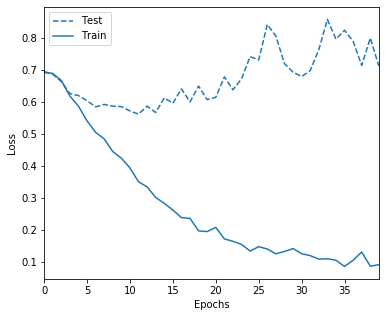

In [88]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model.fit(X_train,
          pd.get_dummies(y_train),
          epochs=40,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
test_loss, test_acc = model.evaluate(X_test, pd.get_dummies(y_test))
print('Test accuracy:', test_acc)

### Recall

In [89]:
from sklearn.metrics import recall_score, accuracy_score, f1_score

In [90]:
recall_score(y_test, model.predict_classes(X_test)),\
accuracy_score(y_test, model.predict_classes(X_test)),\
f1_score(y_test, model.predict_classes(X_test))

(0.6768060836501901, 0.7624045801526718, 0.7408949011446412)

In [91]:
print('전체채팅수{}, 유해채팅수{}'.format(len(X_test),model.predict_classes(X_test).sum()))

전체채팅수1048, 유해채팅수435


In [92]:
print('전체채팅수{}, 유해채팅수{}'.format(len(x_padded),model.predict_classes(x_padded).sum()))

전체채팅수42000, 유해채팅수7841


In [93]:
# model_up.save('../model/cnn_bpe.h5')